# 05wk-1: (신경망) – 예측, 시벤코정리의 이면, 드랍아웃

최규빈  
2025-04-02

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/05wk-1
    .ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wHAizLm_MYaUweataauffD&si=U5TXo5UgkRGc6a-F >}}

# 2. Imports

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 예측

## A. 데이터

In [4]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
eps = torch.randn(100)*0.5
y = x * 4 + 2.5 + eps
x,y = x.reshape(-1,1), y.reshape(-1,1)

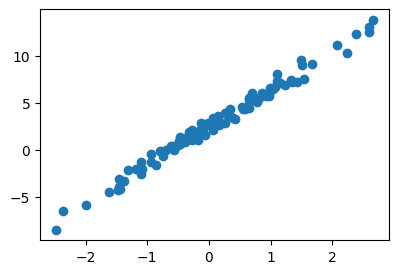

In [5]:
plt.plot(x,y,'o')

## B. 학습

In [15]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
#---#
for epoc in range(200):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

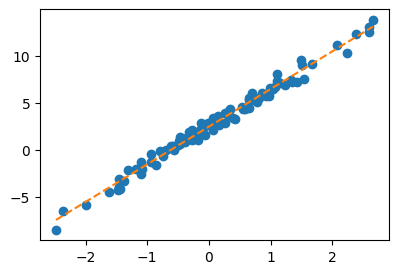

In [16]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

## C. 예측

온도가 0.1 도일때, 커피를 얼마나 팔까?

In [23]:
net[0].weight,net[0].bias

In [24]:
4.0045*0.1 + 2.4457

In [25]:
xx = torch.tensor([[0.1]])
net(xx)

온도가 0.2도일때 커피를 얼마나 팔까?

In [27]:
4.0045*0.2 + 2.4457

In [29]:
xx = torch.tensor([[0.2]])
net(xx)

온도가 \[0.1, 0.2\] 일때의 예측값을 한번에 보고 싶다면?

In [30]:
xx = torch.tensor([[0.1],[0.2]])
net(xx)

# 4. 오버피팅 (시벤코정리의 이면)

## A. 오버피팅

`-` 오버피팅이란?

-   위키: In mathematical modeling, overfitting is “the production of an
    analysis that corresponds too closely or exactly to a particular set
    of data, and may therefore fail to fit to additional data or predict
    future observations reliably”. (수학적 모델링에서 과적합이란 “어떤
    모델이 주어진 데이터에 너무 꼭 맞춰져 있어서, 새로운 데이터나 미래의
    결과를 잘 예측하지 못할 수 있는 상태”를 의미한다.)
-   제 개념: 데이터를 “데이터 = 언더라잉 + 오차”라고 생각할때 우리가
    데이터로부터 적합할 것은 언더라잉인데 오차항을 적합하고 있는 현상.

## B. 오버피팅 예시

`-` $m$이 매우 클때 아래의 네트워크 거의 무엇이든 맞출 수 있다고 보면
된다.

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 그런데 종종 맞추지 말아야 할 것들도 맞춘다.

$$\text{model:} \quad y_i = (0\times x_i) + \epsilon_i,~~ \text{where}~ \epsilon_i \sim N(0,0.01^2)$$

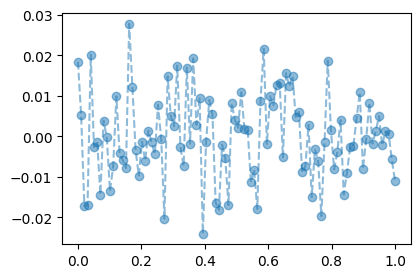

In [67]:
torch.manual_seed(5) 
x = torch.linspace(0,1,100).reshape(100,1)
y = torch.randn(100).reshape(100,1)*0.01
plt.plot(x,y,'--o',alpha=0.5)

In [68]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    yhat=net(x) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    net.zero_grad() 

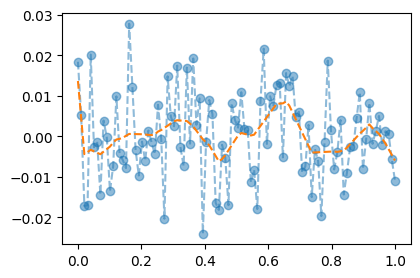

In [69]:
plt.plot(x,y,'--o',alpha=0.5)
plt.plot(x,net(x).data,'--')

-   우리는 데이터를 랜덤에서 뽑았는데, 데이터의 추세를 따라간다 $\to$
    오버피팅 (underlying이 아니라 오차항을 따라가고 있음)

## C. 오버피팅이라는 뚜렷한 증거! (train / test)

`-` 데이터의 분리하여 보자.

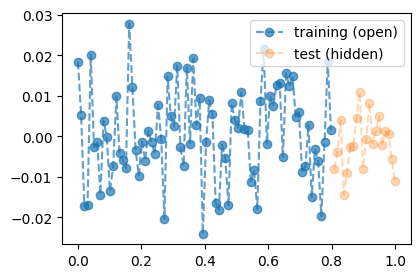

In [73]:
torch.manual_seed(5) 
x_all = torch.linspace(0,1,100).reshape(100,1)
y_all = torch.randn(100).reshape(100,1)*0.01
x = x_all[:80] 
y = y_all[:80]
xx = x_all[80:]
yy = y_all[80:]
plt.plot(x,y,'--o',label="training (open)",alpha=0.7)
plt.plot(xx,yy,'--o',label="test (hidden)",alpha=0.3)
plt.legend()

`-` train만 학습

In [74]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    yhat = net(x) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

`-` training data로 학습한 net를 training data 에 적용

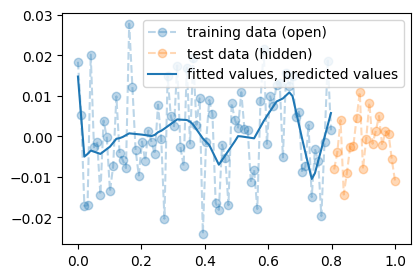

In [75]:
plt.plot(x,y,'--o',label="training data (open)",alpha=0.3)
plt.plot(xx,yy,'--o',label="test data (hidden)",alpha=0.3)
plt.plot(x,net(x).data,label="fitted values, predicted values",color="C0")
plt.legend()

-   train에서는 잘 맞추는듯이 보인다.

`-` training data로 학습한 net를 test data 에 적용

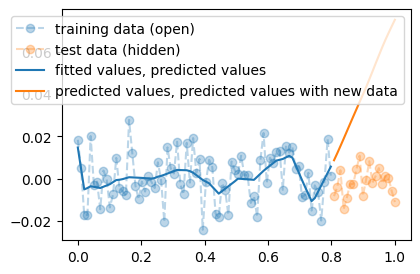

In [76]:
plt.plot(x,y,'--o',label="training data (open)",alpha=0.3)
plt.plot(xx,yy,'--o',label="test data (hidden)",alpha=0.3)
plt.plot(x,net(x).data,label="fitted values, predicted values",color="C0")
plt.plot(xx,net(xx).data,label="predicted values, predicted values with new data",color="C1")
plt.legend()

-   train은 그럭저럭 따라가지만 test에서는 엉망이다. $\to$ overfit

## D. 시벤코정리의 올바른 이해

> **Note**
>
> **시벤코의 항변(?)** (Cybenko 1989)
>
> 하나의 은닉층을 가지는 아래와 같은 꼴의 네트워크
> $net: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$는
>
> ``` python
> net = torch.nn.Sequential(
>     torch.nn.Linear(p,???),
>     torch.nn.Sigmoid(), ## <-- 여기에 렐루를 써도 된다. 
>     torch.nn.Linear(???,q)
> )
> ```
>
> 모든 보렐가측함수
>
> $$f: {\bf X}_{n \times p} \to {\bf y}_{n\times q}$$
>
> 를 원하는 정확도로 “근사”시킬 수 있다. 쉽게 말하면
> ${\bf X} \to {\bf y}$ 인 어떠한 복잡한 규칙라도 하나의 은닉층을 가진
> 신경망이 원하는 정확도로 근사시킨다는 의미이다. **그렇지만 이러한
> 규칙이 네크워크가 학습하지 못했던 자료 (처음 보는 자료, unseen data)**
> ${\bf XX}_{m \times p}$, ${\bf yy}_{m \times p}$ **에 대하여서도
> 올바르게 적용된다라는 보장은 없다**. 시벤코는 단지 `net`가 가지는
> 표현력의 한계를 수학적으로 밝혔을 뿐이다.

# 5. 드랍아웃

## A. 오버피팅의 해결

`-` 오버피팅의 해결책: 드랍아웃

`-` 데이터 – 재활용

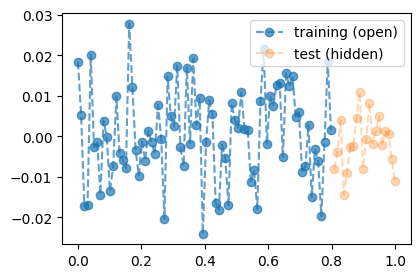

In [77]:
torch.manual_seed(5) 
x_all = torch.linspace(0,1,100).reshape(100,1)
y_all = torch.randn(100).reshape(100,1)*0.01
x = x_all[:80] 
y = y_all[:80]
xx = x_all[80:]
yy = y_all[80:]
plt.plot(x,y,'--o',label="training (open)",alpha=0.7)
plt.plot(xx,yy,'--o',label="test (hidden)",alpha=0.3)
plt.legend()

`-` 학습

In [78]:
torch.manual_seed(1) 
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.8),
    torch.nn.Linear(in_features=512,out_features=1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

for epoc in range(1000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(net(x),y) 
    ## 3 
    loss.backward() 
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화 (잘못된 사용)

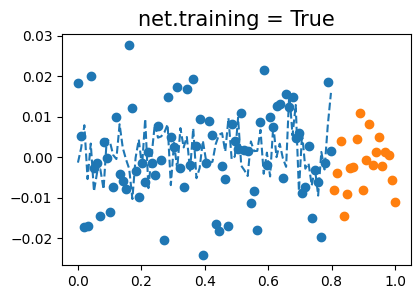

In [79]:
plt.plot(x,y,'o')
plt.plot(xx,yy,'o')
plt.plot(x,net(x).data,'--',color='C0') 
plt.title(f"net.training = {net.training}",fontsize=15)

-   `net`에 드랍아웃이 포함되어 있다면, `net.training  == True` 일때
    결과가 엉망으로 나옴.
-   왜??

`-` 결과시각화 (올바른 사용)

In [80]:
net.training

In [81]:
net.eval()
net.training

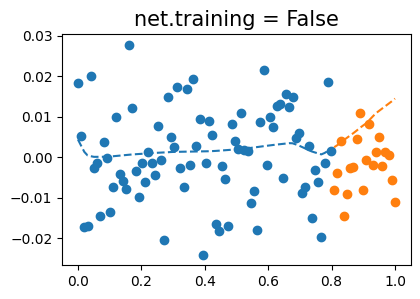

In [82]:
plt.plot(x,y,'o')
plt.plot(xx,yy,'o')
plt.plot(x,net(x).data,'--',color='C0') 
plt.plot(xx,net(xx).data,'--',color='C1') 
plt.title(f"net.training = {net.training}",fontsize=15)

-   이게 제대로 된 결과시각화임!

## B. 드랍아웃 레이어

`-` 드랍아웃의 성질1: 드랍아웃의 계산방식을 이해해보자.

In [781]:
u = torch.randn(20).reshape(10,2)
u

In [782]:
d = torch.nn.Dropout(0.9)
d(u)

-   90%의 드랍아웃: 드랍아웃층의 입력 중 임의로 90%를 골라서 결과를
    0으로 만든다. + 그리고 0이 되지않고 살아남은 값들은 10배 만큼 값이
    커진다.
-   남은값을 10배 키우는 이유? 출력의 평균값을 보정하기 위해서

`-` 드랍아웃의 성질2: 드랍아웃을 on/off 하는 방법을 이해해보자.

In [783]:
u = torch.randn(20).reshape(10,2)
u

In [788]:
net = torch.nn.Sequential(
    torch.nn.Dropout(0.9)
)
net(u), net.training

In [789]:
net.eval()
net(u), net.training

In [790]:
net.train()
net(u), net.training

`-` 드랍아웃레이어 정리

-   계산: (1) 입력의 일부를 임의로 0으로 만드는 역할 (2) 0이 안된것들은
    스칼라배하여 드랍아웃을 통과한 모든 숫자들의 총합이 일정하게 되도록
    조정
-   on/off: 학습시에는 dropout on / 학습을 하지 않을 경우는 dropout off
-   느낌: 일부러 패널티를 안고 학습하는 느낌..
-   효과: 오버피팅을 억제하는 효과가 있음 (왜??)

> 오버피팅을 잡는 방법은 드랍아웃만 있는게 아니다..

## C. 드랍아웃 레이어의 위치

`-` ReLU + dropout의 특이한 성질:
$(\text{dropout} \circ \text{relu})({\bf x})=(\text{relu} \circ \text{dropout})({\bf x})$

In [109]:
dropout = torch.nn.Dropout(0.5)
relu = torch.nn.ReLU()

In [110]:
torch.manual_seed(0)
relu(dropout(u))

In [111]:
torch.manual_seed(0)
dropout(relu(u))

`-` 다른 활성화함수는 성립안함

In [115]:
dropout = torch.nn.Dropout(0.5)
sig = torch.nn.Sigmoid()

In [116]:
torch.manual_seed(0)
sig(dropout(u))

In [117]:
torch.manual_seed(0)
dropout(sig(u))

`-` 결론: 드랍아웃은 히든레이어사이, 즉 활성화 함수 바로 뒤에 오는게
맞음. (그렇지 않다면 0을 만들 수 없는걸?) 그렇지만 ReLU의 경우 활성화
함수 직전에 취하기도 함.

## D. 평균보정의 필요성 (선택학습)

`-` 아래의 데이터를 관찰하자.

In [675]:
x,_ = torch.randn(300).sort()
y = relu(20*x) + torch.randn(300)
x,y = x.reshape(-1,1), y.reshape(-1,1)

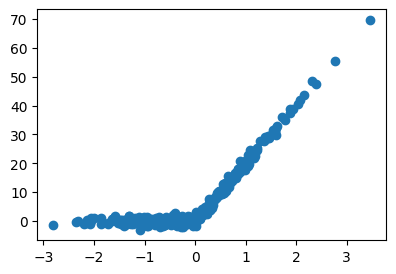

In [676]:
plt.plot(x,y,'o')

`-` 적합해보자.

In [705]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1000),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(1000,1),
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(5000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [706]:
net.eval()

In [707]:
net.training

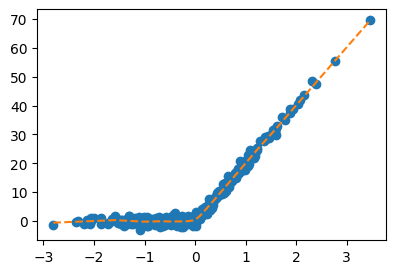

In [708]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

`-` 주황색선이나오는 이유 설명해보자.

In [734]:
U = net[:-1](x).data 
W = net[-1].weight.T 
b = net[-1].bias 

In [736]:
net(x).reshape(-1)[:10]

In [739]:
(U@W+b).reshape(-1)[:10]

In [753]:
((U * W.reshape(-1)).sum(axis=1) +b)[:10]

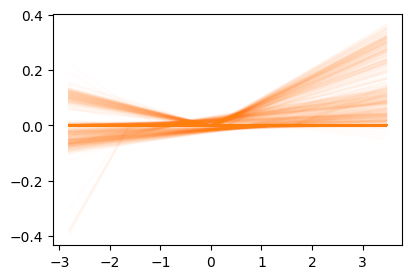

In [759]:
plt.plot(x,U*W.reshape(-1).data,color="C1",alpha=0.02);

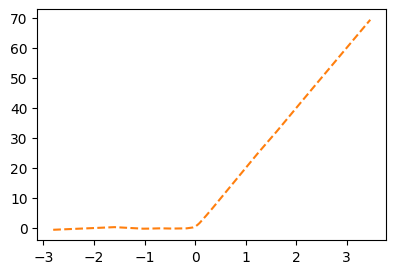

In [764]:
plt.plot(x,net(x).data,'--',color="C1")

# Appendix – 신경망의 표현

신경망의 표현: ${\boldsymbol x} \to \hat{\boldsymbol y}$ 로 가는 과정을
그림으로 표현

## 예제1: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(1)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 모든 observation과 가중치를 명시한 버전

**(표현1)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-4-output-1.svg)

-   단점: 똑같은 그림의 반복이 너무 많음

`-` observation 반복을 생략한 버전들

**(표현2)** 모든 $i$에 대하여 아래의 그림을 반복한다고 하면 (표현1)과
같다.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-5-output-1.svg)

**(표현3)** 그런데 (표현2)에서 아래와 같이 $x_i$, $y_i$ 대신에 간단히
$x$, $y$로 쓰는 경우도 많음

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-6-output-1.svg)

`-` 1을 생략한 버전들

**(표현4)** bais=False 대신에 bias=True를 주면 1을 생략할 수 있음

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-7-output-1.svg)

**(표현4의 수정)** $\hat{w}_1$대신에 $\hat{w}$를 쓰는 것이 더 자연스러움

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-8-output-1.svg)

**(표현5)** 선형변환의 결과는 아래와 같이 $u$로 표현하기도 한다.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-9-output-1.svg)

> 다이어그램은 그리는 사람의 취향에 따라 그리는 방법이 조금씩 다릅니다.
> 즉 교재마다 달라요.

## 예제2: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

**참고: 코드로 표현**

``` python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 이해를 위해서 예젠에 다루었던 아래의 상황을 고려하자.

![](https://guebin.github.io/DL2024/posts/03wk-2_files/figure-html/cell-11-output-1.png)

**(강의노트의 표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-10-output-1.svg)

**(좀 더 일반화된 표현)** 상황을 일반화하면 아래와 같다.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-11-output-1.svg)

`*` Layer의 개념: ${\bf X}$에서 $\hat{\boldsymbol y}$로 가는 과정은
“선형변환+비선형변환”이 반복되는 구조이다. “선형변환+비선형변환”을
하나의 세트로 보면 아래와 같이 표현할 수 있다.

-   $\underset{(n,1)}{\bf X}  \overset{l_1}{\to} \left( \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \right) \overset{l_2}{\to} \left(\underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}\right), \quad  \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{net({\bf X})}=\underset{(n,1)}{\hat{\boldsymbol y}}$

이것을 다이어그램으로 표현한다면 아래와 같다.

**(선형+비선형을 하나의 Layer로 묶은 표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-12-output-1.svg)

***Layer를 세는 방법***

-   제 방식: 학습가능한 파라메터가 몇층으로 있는지… \<– 이것만
    기억하세여
-   일부 교재 설명: 입력층은 계산하지 않음, activation layer는 계산하지
    않음. \<– 무시하세요.. 이러면 헷갈립니다..
-   위의 예제의 경우 `number of layer = 2` 이다.

***Hidden Layer의 수를 세는 방법***

-   제 방식: `Hidden Layer의 수 = Layer의 수 -1` \<– 이걸 기억하세여..  
-   일부 교재 설명:
    `Layer의 수 = Hidden Layer의 수 + 출력층의 수 = Hidden Layer의 수 + 1`
    \<– 기억하지 마세여
-   위의 예제의 경우 `number of hidden layer = 1` 이다.

> **Important**
>
> 무조건 학습가능한 파라메터가 몇겹으로 있는지만 판단하세요. 딴거
> 아무것도 생각하지마세여
>
> ``` python
> ## 예시1 -- 2층 (히든레이어는 1층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU(),
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
> )
> ```
>
> ``` python
> ## 예시2 -- 2층 (히든레이어는 1층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU(),
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid(),
> )
> ```
>
> ``` python
> ## 예시3 -- 1층 (히든레이어는 없음!!)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
> ) 
> ```
>
> ``` python
> ## 예시4 -- 1층 (히든레이어는 없음!!)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
> ) 
> ```
>
> ``` python
> ## 예시5 -- 3층 (히든레이어는 2층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층    
> ) 
> ```
>
> ``` python
> ## 예시6 -- 3층 (히든레이어는 2층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU()
>     torch.nn.Dropout(??)
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU()
>     torch.nn.Dropout(??)
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층  
>     torch.nn.Sigmoid()
> ) 
> ```

> **Important**
>
> 문헌에 따라서 레이어를 세는 개념이 제가 설명한 방식과 다른경우가
> 있습니다. 제가 설명한 방식보다 1씩 더해서 셉니다. 즉 아래의 경우
> 레이어를 3개로 카운트합니다.
>
> ``` python
> ## 예시1 -- 문헌에 따라 3층으로 세는 경우가 있음 (히든레이어는 1층)
> torch.nn.Sequential(
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.ReLU(),
>     torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
>     torch.nn.Sigmoid()
> )
> ```
>
> 예를 들어
> [여기](https://en.wikipedia.org/wiki/Multilayer_perceptron#Layers)에서는
> 위의 경우 레이어는 3개라고 설명하고 있습니다. 이러한 카운팅은
> **“무시”하세요. 제가 설명한 방식이 맞아요.** [이
> 링크](https://en.wikipedia.org/wiki/Multilayer_perceptron#Layers)
> 잘못(?) 나와있는 이유는 아래와 같습니다.
>
> `-` 진짜 예전에 MLP를 소개할 초창기에서는 위의 경우 Layer를 3개로
> 셌음. (Rosenblatt et al. 1962)
>
> `-` 그런데 요즘은 그렇게 안셈.. (그리고 애초에 MLP라는 용어도 잘
> 안쓰죠..)
>
> 참고로 히든레이어의 수는 예전방식이나 지금방식이나 동일하게
> 카운트하므로 히든레이어만 세면 혼돈이 없습니다.

`*` node의 개념: $u\to v$로 가는 쌍을 간단히 노드라는 개념을 이용하여
나타낼 수 있음.

**(노드의 개념이 포함된 그림)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-13-output-1.svg)

여기에서 `node의 숫자 = feature의 숫자`와 같이 이해할 수 있다. 즉 아래와
같이 이해할 수 있다.

**(“number of nodes = number of features”로 이해한 그림)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-14-output-1.svg)

> 다이어그램의 표현방식은 교재마다 달라서 모든 예시를 달달 외울 필요는
> 없습니다. 다만 임의의 다이어그램을 보고 대응하는 네트워크를 pytorch로
> 구현하는 능력은 매우 중요합니다.

## 예제3: $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

**(다이어그램표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-15-output-1.svg)

-   Layer0,1,2 대신에 Input Layer, Hidden Layer, Output Layer로 표현함

`-` 위의 다이어그램에 대응하는 코드

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28*1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid() 
)
```

Cybenko, George. 1989. “Approximation by Superpositions of a Sigmoidal
Function.” *Mathematics of Control, Signals and Systems* 2 (4): 303–14.

Rosenblatt, Frank et al. 1962. *Principles of Neurodynamics: Perceptrons
and the Theory of Brain Mechanisms*. Vol. 55. Spartan books Washington,
DC.